In [33]:
#Dummy notebook for testing out
from pathlib import Path

In [29]:

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary

from modules import data_setup, engine

from modules.helper_functions import set_seeds,plot_loss_curves




In [30]:

# Set device to CUDA if available, else use Metal Performance Shaders (MPS) on macOS
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [31]:
device

'mps'

In [34]:
# Download pizza, steak, sushi images from GitHub for learning purpose
image_path =  Path("data/alzheimer_ dataset/")
image_path

PosixPath('data/alzheimer_ dataset')

In [35]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [36]:
## Create datasets and data loaders
# training resolution used in vit is 224

from torchvision import transforms

IMG_SIZE = 224
BATCH_SIZE = 32

pretrained_vit_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor()
    ]
)


In [37]:
#pretrained weights for ViT base
pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

#setup a vit model instance 
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_weights).to(device)
pretrained_weights

ViT_B_16_Weights.IMAGENET1K_V1

In [38]:
# get automatic transforms from weights
vit_transforms = pretrained_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [39]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_data_loaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) #could set higher cos it's pretrained

In [40]:
#freeze the base vit
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

In [41]:
#update the MLP head(classifier head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,out_features=len(class_names)).to(device)

In [42]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 4]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Train feature extractor ViT model

In [43]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr= 1e-3) #trainable parameter in the head layer
loss_fn = torch.nn.CrossEntropyLoss()

#train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model= pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader= test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                    epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0084 | train_acc: 0.0023 | test_loss: 1.2525 | test_acc: 0.3500
Epoch: 2 | train_loss: 0.0073 | train_acc: 0.0025 | test_loss: 1.1511 | test_acc: 0.3586
Epoch: 3 | train_loss: 0.0072 | train_acc: 0.0025 | test_loss: 1.0835 | test_acc: 0.4409
Epoch: 4 | train_loss: 0.0065 | train_acc: 0.0033 | test_loss: 1.0512 | test_acc: 0.4955
Epoch: 5 | train_loss: 0.0064 | train_acc: 0.0027 | test_loss: 1.0356 | test_acc: 0.4955
Epoch: 6 | train_loss: 0.0050 | train_acc: 0.0041 | test_loss: 1.0282 | test_acc: 0.5235
Epoch: 7 | train_loss: 0.0067 | train_acc: 0.0027 | test_loss: 1.0263 | test_acc: 0.5157
Epoch: 8 | train_loss: 0.0058 | train_acc: 0.0033 | test_loss: 1.0266 | test_acc: 0.5104
Epoch: 9 | train_loss: 0.0053 | train_acc: 0.0041 | test_loss: 1.0162 | test_acc: 0.5329
Epoch: 10 | train_loss: 0.0064 | train_acc: 0.0027 | test_loss: 1.0098 | test_acc: 0.5352


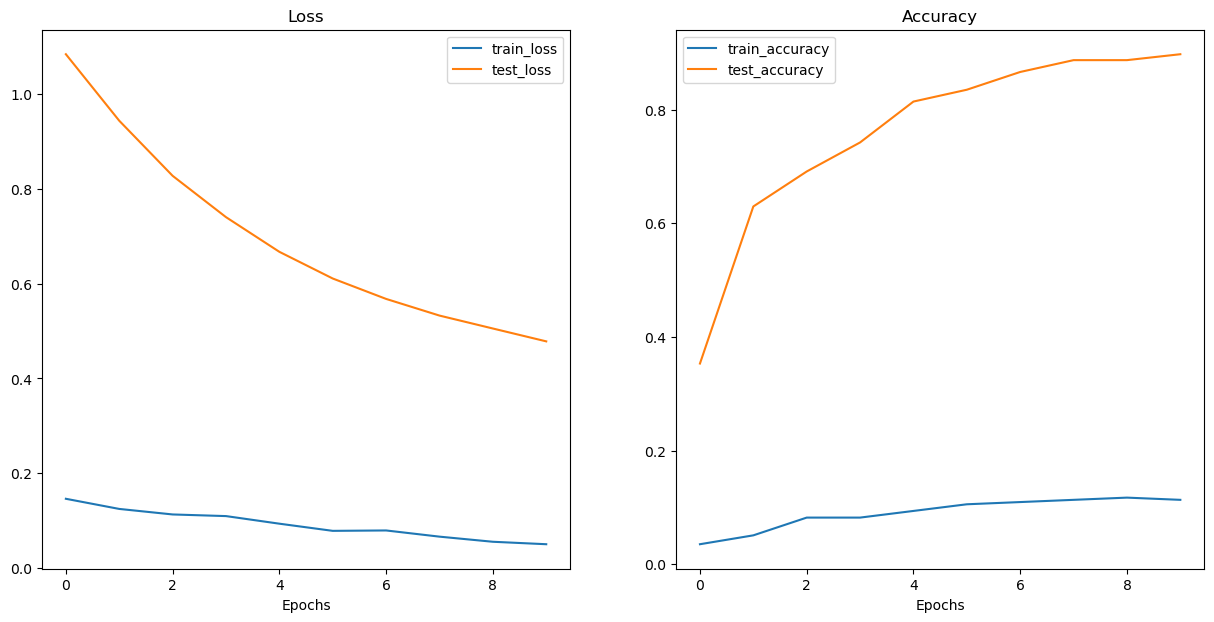

In [24]:
plot_loss_curves(pretrained_vit_results)

### Saving our model

In [44]:
from modules import utils


utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="alzheimer_detect_team_5.pth"
                 )

[INFO] Saving model to: models/alzheimer_detect_team_5.pth
